<a href="https://colab.research.google.com/github/Cairo-Henrique/Analise-Fundamentalista/blob/main/analise_fundamentalista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd

# Definição de limites para avaliação
THRESHOLDS = {
    'trailingPE': {'good': (0, 15), 'label': 'P/L (Price to Earnings)'},
    'priceToBook': {'good': (0, 1.5), 'label': 'P/VPA (Price to Book)'},
    'returnOnEquity': {'good': (0.15, None), 'label': 'ROE (Return on Equity)'},
    'returnOnAssets': {'good': (0.05, None), 'label': 'ROA (Return on Assets)'},
    'debtToEquity': {'good': (None, 1), 'label': 'Dívida/Patrimônio'},
    'currentRatio': {'good': (1.5, None), 'label': 'Current Ratio'},
    'profitMargins': {'good': (0.1, None), 'label': 'Margem Líquida'},
    'operatingMargins': {'good': (0.1, None), 'label': 'Margem Operacional'},
    'dividendYield': {'good': (0.02, None), 'label': 'Dividend Yield'},
    'grahamFairPrice': {'good': (None, None), 'label': 'Preço Justo (Graham)'}
}

def get_financial_indicators(ticker_symbol):
    """
    Retorna um dicionário com indicadores financeiros de uma empresa, dado seu ticker.
    """
    ticker = yf.Ticker(ticker_symbol)
    info = ticker.info

    eps = info.get('trailingEps')
    growth = info.get('earningsGrowth')
    graham_price = None
    if eps is not None and growth is not None:
        graham_price = eps * (8.5 + 2 * (growth * 100))  # growth está como fração, ex: 0.1 = 10%


    return {
        'Ticker': ticker_symbol.upper(),
        'Nome': info.get('longName'),
        'Setor': info.get('sector'),
        'Indústria': info.get('industry'),
        'Preço Atual': info.get('currentPrice'),
        'Market Cap': info.get('marketCap'),
        'trailingPE': info.get('trailingPE'),
        'priceToBook': info.get('priceToBook'),
        'returnOnEquity': info.get('returnOnEquity'),
        'returnOnAssets': info.get('returnOnAssets'),
        'debtToEquity': info.get('debtToEquity'),
        'currentRatio': info.get('currentRatio'),
        'profitMargins': info.get('profitMargins'),
        'operatingMargins': info.get('operatingMargins'),
        'dividendYield': info.get('dividendYield'),
        'grahamFairPrice': graham_price,
    }

def evaluate_indicators(indicators):
    """
    Avalia cada indicador com base nos limites definidos em THRESHOLDS.
    Retorna um dicionário com status: 'Bom', 'Ruim' ou 'Dados não disponíveis'.
    """
    avaliacoes = {}
    for key, params in THRESHOLDS.items():
        value = indicators.get(key)
        low, high = params['good']
        label = params['label']

        if value is None:
            status = 'Dados não disponíveis'
        elif key == 'grahamFairPrice':
            preco_atual = indicators.get('Preço Atual')
            if preco_atual is None or value is None:
                status = 'Dados não disponíveis'
            else:
                status = 'Bom' if preco_atual < value else 'Ruim'

        else:
            ok_low = (low is None) or (value >= low)
            ok_high = (high is None) or (value <= high)
            status = 'Bom' if ok_low and ok_high else 'Ruim'

        avaliacoes[label] = status
    return avaliacoes

def compare_companies(tickers):
    """
    Compara várias empresas, mostra indicadores e retorna ranking com base na quantidade de indicadores "Bom".
    """
    resultados = []
    for t in tickers:
        try:
            data = get_financial_indicators(t)
            avals = evaluate_indicators(data)

            print(f"\n=== Indicadores de {data['Ticker']} ({data['Nome']}) ===")
            for key, val in THRESHOLDS.items():
                label = val['label']
                valor = data.get(key)
                status = avals[label]
                print(f"{label}: {valor} -> {status}")

            qtd_bom = sum(1 for s in avals.values() if s == 'Bom')
            total = len([s for s in avals.values() if s != 'Dados não disponíveis'])
            score = qtd_bom / total if total > 0 else 0
            resultados.append({
                'Ticker': data['Ticker'],
                'Nome': data['Nome'],
                'Bom': qtd_bom,
                'Total Avaliados': total,
                'Score': round(score, 2)
            })
        except Exception:
            print(f"Erro ao obter dados para {t.upper()}.")
            resultados.append({'Ticker': t.upper(), 'Nome': None, 'Bom': 0, 'Total Avaliados': 0, 'Score': 0})

    df = pd.DataFrame(resultados)
    df_ranked = df.sort_values(by='Score', ascending=False).reset_index(drop=True)
    return df_ranked

if __name__ == '__main__':
    entrada = input('Digite os tickers das empresas separados por vírgula (ex: AAPL, MSFT, GOOGL): ')
    tickers = [t.strip() for t in entrada.split(',') if t.strip()]

    # Compara, mostra indicadores e gera ranking
    ranking = compare_companies(tickers)

    print("\n=== Ranking de Empresas ===")
    print(ranking.to_string(index=False))
    print("\nLegenda: 'Bom' = número de indicadores dentro dos limites; 'Total Avaliados' = indicadores disponíveis; 'Score' = proporção de 'Bom'.")

# Cálculo de desempenho em X meses
    while True:
        try:
            meses = int(input("\nDeseja ver o desempenho dos ativos nos últimos quantos meses? (Digite 0 para sair): "))
            if meses <= 0:
                break
            print(f"\nVariação percentual dos ativos nos últimos {meses} meses:")
            for t in tickers:
                try:
                    hist = yf.Ticker(t).history(period=f"{meses}mo")
                    if len(hist) >= 2:
                        preco_inicio = hist['Close'].iloc[0]
                        preco_fim = hist['Close'].iloc[-1]
                        variacao = (preco_fim - preco_inicio) / preco_inicio * 100
                        print(f"{t}: {variacao:.2f}%")
                    else:
                        print(f"{t}: Dados insuficientes.")
                except Exception:
                    print(f"{t}: Erro ao obter dados.")
        except ValueError:
            print("Entrada inválida. Tente novamente.")

Digite os tickers das empresas separados por vírgula (ex: AAPL, MSFT, GOOGL): SBSP3.SA, SAPR3.SA, CSMG3.SA, CASN3.SA, ORVR3.SA, AMBIP3.SA 

=== Indicadores de SBSP3.SA (Companhia de Saneamento Básico do Estado de São Paulo - SABESP) ===
P/L (Price to Earnings): 7.2784576 -> Bom
P/VPA (Price to Book): 2.0099373 -> Ruim
ROE (Return on Equity): 0.3091 -> Bom
ROA (Return on Assets): 0.1443 -> Bom
Dívida/Patrimônio: 77.35 -> Ruim
Current Ratio: 1.265 -> Ruim
Margem Líquida: 0.27754998 -> Bom
Margem Operacional: 0.3718 -> Bom
Dividend Yield: 3.14 -> Bom
Preço Justo (Graham): 2632.374 -> Bom

=== Indicadores de SAPR3.SA (Companhia de Saneamento do Paraná - SANEPAR) ===
P/L (Price to Earnings): 5.6000004 -> Bom
P/VPA (Price to Book): 1.005386 -> Bom
ROE (Return on Equity): 0.20599002 -> Bom
ROA (Return on Assets): 0.04873 -> Ruim
Dívida/Patrimônio: 56.839 -> Ruim
Current Ratio: 1.211 -> Ruim
Margem Líquida: 0.32334 -> Bom
Margem Operacional: 0.31884 -> Bom
Dividend Yield: 6.65 -> Bom
Preço Jus

ERROR:yfinance:HTTP Error 404: 



=== Indicadores de AMBIP3.SA (None) ===
P/L (Price to Earnings): None -> Dados não disponíveis
P/VPA (Price to Book): None -> Dados não disponíveis
ROE (Return on Equity): None -> Dados não disponíveis
ROA (Return on Assets): None -> Dados não disponíveis
Dívida/Patrimônio: None -> Dados não disponíveis
Current Ratio: None -> Dados não disponíveis
Margem Líquida: None -> Dados não disponíveis
Margem Operacional: None -> Dados não disponíveis
Dividend Yield: None -> Dados não disponíveis
Preço Justo (Graham): None -> Dados não disponíveis

=== Ranking de Empresas ===
   Ticker                                                           Nome  Bom  Total Avaliados  Score
 CSMG3.SA                        Companhia de Saneamento de Minas Gerais    8               10   0.80
 SBSP3.SA Companhia de Saneamento Básico do Estado de São Paulo - SABESP    7               10   0.70
 SAPR3.SA                    Companhia de Saneamento do Paraná - SANEPAR    6               10   0.60
 ORVR3.SA         

KeyboardInterrupt: Interrupted by user

In [ ]:
import yfinance as yf
import pandas as pd

# Define os tickers
tickers = ['BBAS3.SA', 'BBSE3.SA']

# Baixa os dados dos últimos 12 meses
dados = yf.download(tickers, period='12mo')

# Acessa a coluna 'Close' no MultiIndex
adj_close_data = dados['Close']

# Remove dias com valores ausentes
adj_close_data = adj_close_data.dropna()

# Calcula os retornos diários
retornos = adj_close_data.pct_change().dropna()

# Calcula a matriz de covariância
covariancia = retornos.cov()

# Exibe a covariância entre os dois ativos
print("Covariância entre BBAS3 e BBSE3:")
print(covariancia.loc['BBAS3.SA', 'BBSE3.SA'])

/tmp/ipython-input-17-2328877306.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers, period='12mo')
[*********************100%***********************]  2 of 2 completed

Covariância entre BBAS3 e BBSE3:
6.277321580276927e-05


Tickers separados por vírgula (ex: AAPL, MSFT, GOOG): BBAS3.SA, CSMG3.SA
Data inicial (YYYY-MM-DD) [padrão 2018-01-01]: 2021-01-01
Data final (YYYY-MM-DD) [opcional, ENTER para hoje]: 2025-08-22
Permitir posições short? (s/n) [padrão n]: n
Taxa livre de risco anual (ex: 0.02) [padrão 0.02]: 0.02

Baixando preços...
Tentando download em lote (threads=False)...
Download em lote bem-sucedido.
Retornos anualizados calculados.
Gerando portfólios aleatórios (visualização)...
Calculando efficient frontier (otimizações)...


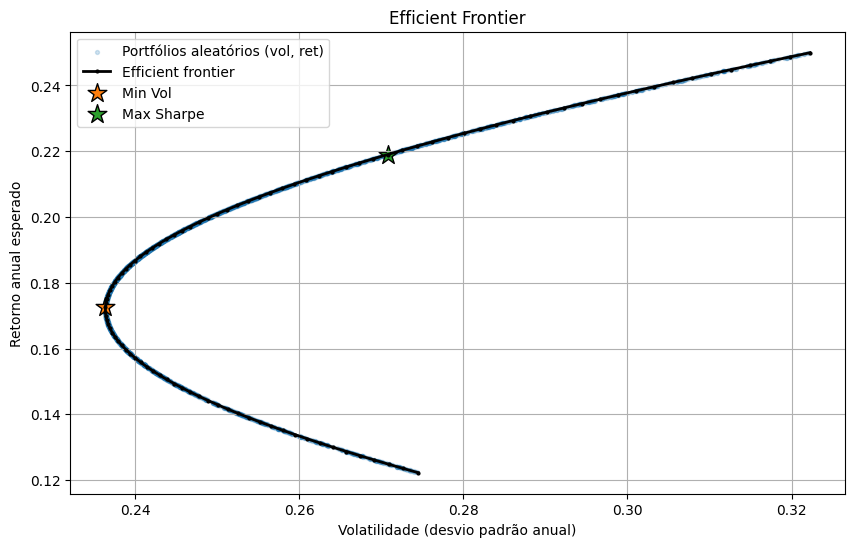


Portfólio de MÍNIMA VARIÂNCIA (weights em %):
          Percentual (%)
Ticker                  
BBAS3.SA           60.61
CSMG3.SA           39.39

Portfólio de MÁXIMA SHARPE (weights em %):
          Percentual (%)
Ticker                  
CSMG3.SA           75.76
BBAS3.SA           24.24

Métrica dos portfólios destacados:
Min Vol -> Retorno: 0.1726, Vol: 0.2364, Sharpe: 0.6454
Max Sharpe -> Retorno: 0.2190, Vol: 0.2708, Sharpe: 0.7349


KeyboardInterrupt: Interrupted by user

In [ ]:
"""
efficient_frontier.py

Uso:
    python efficient_frontier.py
    -> digite tickers separados por vírgula (ex: AAPL, MSFT, GOOG)
Pré-requisitos:
    pip install yfinance numpy pandas scipy matplotlib
"""

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import time
import yfinance as yf
import pandas as pd
from typing import List, Optional

plt.rcParams['figure.figsize'] = (10, 6)

def fetch_prices(tickers: List[str],
                 start: str = "2018-01-01",
                 end: Optional[str] = None,
                 max_retries_per_ticker: int = 3,
                 retry_delay: float = 1.0) -> pd.DataFrame:
    """
    Baixa preços ajustados (auto_adjust=True) para a lista de tickers.
    - Primeiro tenta um download em lote com threads desativadas (threads=False).
    - Se algo falhar ou resultar em dados incompletos, faz fallback buscando ticker a ticker.
    - Retorna DataFrame com preços (colunas = tickers). Remove colunas vazias.
    """
    tickers = [t.strip() for t in tickers if t.strip()]
    if len(tickers) == 0:
        raise ValueError("Nenhum ticker válido informado.")

    # 1) Tentativa em lote (sem threads) — reduz chance de "database is locked"
    try:
        print("Tentando download em lote (threads=False)...")
        data = yf.download(tickers,
                           start=start,
                           end=end,
                           progress=False,
                           threads=False,
                           auto_adjust=True)
        # yf.download com múltiplos tickers devolve DataFrame com colunas simples (Adj Close/Close)
        # Dependendo da versão, pode retornar Series para um ticker só; padronizar:
        if isinstance(data, pd.Series):
            data = data.to_frame(data.name)
        # Se veio MultiIndex (quando múltiplas colunas como 'Close','Volume'), tentar extrair Close
        if isinstance(data.columns, pd.MultiIndex):
            # preferir 'Close' (já auto_adjust=True) ou 'Adj Close'
            for colname in ("Close", "Adj Close"):
                if colname in data.columns.levels[0]:
                    data = data[colname]
                    break
        # filtrar apenas colunas pedidas e dropar colunas totalmente vazias
        data = data.reindex(columns=tickers, fill_value=None)
        data = data.dropna(how="all", axis=1)
        if not data.empty and set(data.columns) == set(tickers):
            print("Download em lote bem-sucedido.")
            return data

        print("Download em lote incompleto ou retornou menos tickers do que o solicitado. Fará fallback ticker-a-ticker...")
    except Exception as e:
        print(f"Atenção: falha no download em lote: {type(e).__name__}: {e!s}")
        print("Fazendo fallback buscando ticker a ticker...")

    # 2) Fallback: buscar ticker a ticker (mais seguro, menor chance de travamento)
    frames = {}
    for t in tickers:
        success = False
        for attempt in range(1, max_retries_per_ticker + 1):
            try:
                # usamos Ticker.history (auto_adjust=True) para evitar avisos de FutureWarning
                tf = yf.Ticker(t).history(start=start, end=end, auto_adjust=True)
                # Pode vir com colunas (Open, High, Close, ...). Pegar "Close" que já está ajustado.
                if tf is not None and not tf.empty:
                    if "Close" in tf.columns:
                        frames[t] = tf["Close"].rename(t)
                    elif "Adj Close" in tf.columns:
                        frames[t] = tf["Adj Close"].rename(t)
                    else:
                        # se só houver um column, pegar primeira coluna
                        frames[t] = tf.iloc[:, 0].rename(t)
                    success = True
                    break
                else:
                    print(f"[{t}] tentativa {attempt}: sem dados retornados.")
            except Exception as e:
                # pegar mensagens mais amigáveis para debug
                print(f"[{t}] tentativa {attempt} falhou: {type(e).__name__}: {e}")
            time.sleep(retry_delay)  # backoff curto antes de tentar novamente

        if not success:
            print(f"Erro persistente: não foi possível obter dados para {t} (será omitido).")

    if len(frames) == 0:
        # nenhum ticker obteve dados
        return pd.DataFrame()

    # concatenar, alinhando por índice (datas)
    df = pd.concat(frames.values(), axis=1)
    df.columns = list(frames.keys())
    # remover colunas vazias (caso algum ticker tenha falhado)
    df = df.dropna(how="all", axis=1)
    return df

def compute_annualized_stats(price_df, trading_days=252):
    daily_ret = price_df.pct_change().dropna()
    mean_daily = daily_ret.mean()
    cov_daily = daily_ret.cov()
    mean_annual = mean_daily * trading_days
    cov_annual = cov_daily * trading_days
    return mean_annual, cov_annual, daily_ret

def portfolio_performance(weights, mean_returns, cov_matrix, risk_free=0.0):
    ret = float(np.dot(weights, mean_returns))
    vol = float(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))
    sharpe = (ret - risk_free) / vol if vol > 0 else 0.0
    return ret, vol, sharpe

def minimize_vol_for_target_return(target_return, mean_returns, cov_matrix, allow_short=False):
    n = len(mean_returns)
    args = (cov_matrix,)
    # objective: portfolio variance
    def portfolio_var(w, cov):
        return float(np.dot(w.T, np.dot(cov, w)))
    # constraints: weights sum to 1, portfolio return = target_return
    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target_return}
    )
    # bounds
    if allow_short:
        bnds = [(-1.0, 1.0) for _ in range(n)]
    else:
        bnds = [(0.0, 1.0) for _ in range(n)]
    init_guess = np.array([1.0 / n] * n)
    res = minimize(portfolio_var, init_guess, args=args, method='SLSQP', bounds=bnds, constraints=cons)
    if not res.success:
        # tentar com outra inicialização
        for i in range(n):
            guess = np.roll(init_guess, i)
            res = minimize(portfolio_var, guess, args=args, method='SLSQP', bounds=bnds, constraints=cons)
            if res.success:
                break
    return res

def efficient_frontier(mean_returns, cov_matrix, returns_count=100, allow_short=False):
    # gera target returns no intervalo [min możliwy, max możliwy]
    min_ret = float(np.min(mean_returns))
    max_ret = float(np.max(mean_returns))
    # se min == max (caso raro), criar pequena grade
    if np.isclose(min_ret, max_ret):
        targets = np.linspace(min_ret * 0.8, max_ret * 1.2, returns_count)
    else:
        targets = np.linspace(min_ret, max_ret, returns_count)
    frontier_weights = []
    frontier_returns = []
    frontier_vols = []
    for tr in targets:
        res = minimize_vol_for_target_return(tr, mean_returns, cov_matrix, allow_short=allow_short)
        if res.success:
            w = res.x
            r, v, s = portfolio_performance(w, mean_returns, cov_matrix)
            frontier_weights.append(w)
            frontier_returns.append(r)
            frontier_vols.append(v)
        else:
            # pular ponto se não convergir
            continue
    return np.array(frontier_weights), np.array(frontier_returns), np.array(frontier_vols)

def random_portfolios(mean_returns, cov_matrix, num_portfolios=5000, allow_short=False, risk_free=0.0):
    n = len(mean_returns)
    results = np.zeros((num_portfolios, 3))  # ret, vol, sharpe
    weights_record = np.zeros((num_portfolios, n))
    for i in range(num_portfolios):
        if allow_short:
            # permitir pesos negativos, mas normalizar
            w = np.random.uniform(-1, 1, n)
        else:
            w = np.random.random(n)
        w /= np.sum(np.abs(w)) if allow_short else np.sum(w)
        ret, vol, sharpe = portfolio_performance(w, mean_returns, cov_matrix, risk_free=risk_free)
        results[i] = [ret, vol, sharpe]
        weights_record[i, :] = w
    return results, weights_record

def find_min_vol_and_max_sharpe(weights_grid, mean_returns, cov_matrix, risk_free=0.0):
    # weights_grid: list/array of weights to evaluate (e.g., frontier_weights)
    rets = []
    vols = []
    sharpes = []
    for w in weights_grid:
        r, v, s = portfolio_performance(w, mean_returns, cov_matrix, risk_free=risk_free)
        rets.append(r); vols.append(v); sharpes.append(s)
    rets = np.array(rets); vols = np.array(vols); sharpes = np.array(sharpes)
    min_vol_idx = np.argmin(vols)
    max_sharpe_idx = np.argmax(sharpes)
    return min_vol_idx, max_sharpe_idx, rets, vols, sharpes

def main():
    # inputs do usuário
    tickers_input = input("Tickers separados por vírgula (ex: AAPL, MSFT, GOOG): ").upper()
    tickers = [t.strip() for t in tickers_input.split(",") if t.strip()]
    if not tickers:
        print("Nenhum ticker válido informado. Saindo.")
        return

    start = input("Data inicial (YYYY-MM-DD) [padrão 2018-01-01]: ").strip() or "2018-01-01"
    end = input("Data final (YYYY-MM-DD) [opcional, ENTER para hoje]: ").strip() or None
    allow_short_input = input("Permitir posições short? (s/n) [padrão n]: ").strip().lower() or "n"
    allow_short = allow_short_input.startswith("s")
    risk_free = input("Taxa livre de risco anual (ex: 0.02) [padrão 0.02]: ").strip()
    risk_free = float(risk_free) if risk_free else 0.02

    print("\nBaixando preços...")
    prices = fetch_prices(tickers, start=start, end=end)
    if prices.empty:
        print("Erro: não foram obtidos preços. Verifique os tickers e as datas.")
        return

    mean_returns, cov_matrix, daily_ret = compute_annualized_stats(prices)
    print("Retornos anualizados calculados.")

    # gerar portfólios aleatórios para visualização
    print("Gerando portfólios aleatórios (visualização)...")
    rnd_results, rnd_weights = random_portfolios(mean_returns, cov_matrix, num_portfolios=3000, allow_short=allow_short, risk_free=risk_free)

    # calcular efficient frontier
    print("Calculando efficient frontier (otimizações)...")
    fw, frets, fvols = efficient_frontier(mean_returns, cov_matrix, returns_count=100, allow_short=allow_short)

    if fw.size == 0:
        print("Não foi possível construir a efficient frontier.")
        return

    # encontrar mínimos e máximos
    min_vol_idx, max_sharpe_idx, fr_rets, fr_vols, fr_sharpes = find_min_vol_and_max_sharpe(fw, mean_returns, cov_matrix, risk_free=risk_free)

    min_vol_weights = fw[min_vol_idx]
    max_sharpe_weights = fw[max_sharpe_idx]

    # Plot
    fig, ax = plt.subplots()
    ax.scatter(rnd_results[:,1], rnd_results[:,0], alpha=0.2, label='Portfólios aleatórios (vol, ret)', s=8)
    ax.plot(fvols, frets, 'k.-', linewidth=2, markersize=4, label='Efficient frontier')
    ax.scatter([fr_vols[min_vol_idx]], [fr_rets[min_vol_idx]], marker='*', s=200, label='Min Vol', edgecolors='k')
    ax.scatter([fr_vols[max_sharpe_idx]], [fr_rets[max_sharpe_idx]], marker='*', s=200, label='Max Sharpe', edgecolors='k')
    ax.set_xlabel('Volatilidade (desvio padrão anual)')
    ax.set_ylabel('Retorno anual esperado')
    ax.set_title('Efficient Frontier')
    ax.legend()
    plt.grid(True)
    plt.show()

    # Mostrar resultados (percentagens)
    def show_weights_table(weights, title):
        df = pd.DataFrame(weights.reshape(1, -1), columns=mean_returns.index)
        df_perc = (df * 100).round(2).T.rename(columns={0: 'Percentual (%)'}).sort_values('Percentual (%)', ascending=False)
        print(f"\n{title}")
        print(df_perc.to_string())

    show_weights_table(min_vol_weights, "Portfólio de MÍNIMA VARIÂNCIA (weights em %):")
    show_weights_table(max_sharpe_weights, "Portfólio de MÁXIMA SHARPE (weights em %):")

    # Mostrar retornos/volatilidade/sharpe
    min_r, min_v, min_s = portfolio_performance(min_vol_weights, mean_returns, cov_matrix, risk_free=risk_free)
    max_r, max_v, max_s = portfolio_performance(max_sharpe_weights, mean_returns, cov_matrix, risk_free=risk_free)
    print("\nMétrica dos portfólios destacados:")
    print(f"Min Vol -> Retorno: {min_r:.4f}, Vol: {min_v:.4f}, Sharpe: {min_s:.4f}")
    print(f"Max Sharpe -> Retorno: {max_r:.4f}, Vol: {max_v:.4f}, Sharpe: {max_s:.4f}")

    # Opcional: criar DataFrame com os pesos de cada ponto da frontier e salvar
    save_csv = input("\nSalvar tabela com pesos de cada ponto da frontier em CSV? (s/n) [padrão n]: ").strip().lower() or "n"
    if save_csv.startswith("s"):
        weights_df = pd.DataFrame(fw, columns=mean_returns.index)
        weights_df.index = [f"{r:.4f}" for r in frets]  # index pelo retorno esperado
        filename = "efficient_frontier_weights.csv"
        weights_df.to_csv(filename)
        print(f"Salvo: {filename}")

if __name__ == "__main__":
    main()
